In [1]:
import numpy as np
import scipy
import dirichlet

In [77]:
def est_mixed_dirichlet(samples):
    # given (N, D) samples which may contain zeros
    # estimate the parameters of a mixed dirichlet distribution (K, D)
    # where K is the number of dirichlet components
    # and D is the dimensionality of the dirichlet components

    # first determine the classes
    N, D = samples.shape
    classes, class_idxs, class_counts = np.unique(samples > 0, axis=0, return_inverse=True, return_counts=True)
    pi = class_counts / N
    K = len(classes)
    # then estimate the parameters for each class
    alphas = np.zeros_like(classes, dtype=np.float64)
    for i, c in enumerate(classes):
        class_samples = samples[class_idxs == i][:, c]
        alpha = dirichlet.mle(class_samples)
        alphas[i][c] = alpha
    return classes, class_idxs, alphas, pi

samples_1 = scipy.stats.dirichlet.rvs([1, 2, 3], size=50)
samples_1 = np.hstack([samples_1, np.zeros((50, 1))])
samples_2 = scipy.stats.dirichlet.rvs([3, 2, 1], size=100)
samples_2 = np.hstack([np.zeros((100, 1)), samples_2])
samples = np.vstack([samples_1, samples_2])
classes, class_idxs, alphas, pi = est_mixed_dirichlet(samples)
classes, class_idxs, alphas, pi

(array([[False,  True,  True,  True],
        [ True,  True,  True, False]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([[0.        , 3.14231368, 1.98213625, 1.13411201],
        [0.90874459, 1.952118  , 2.863891  , 0.        ]]),
 array([0.66666667, 0.33333333]))

In [78]:
np.where([True, False, True])[0]

array([0, 2])

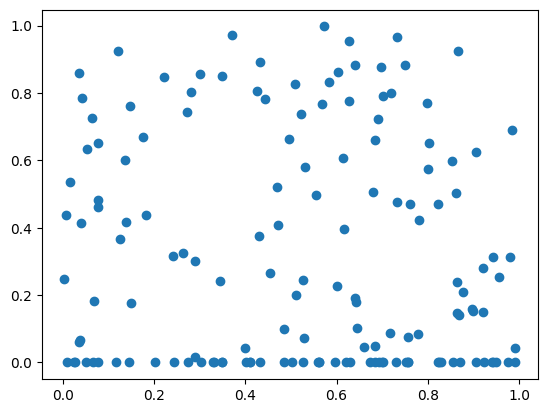

In [82]:
def unif_dirichlet_samples(samples, alpha):
    # given (N, E) samples from a dirichlet distribution with parameter alpha
    # sequentially evaluate the inverse cdf of the dirichlet distribution
    # to map the samples to uniform rvs
    # we want to use beta dists
    a = alpha # alpha weight per entry
    b = alpha.sum() - alpha.cumsum()  # remaining alpha weight
    betas = scipy.stats.beta(a[:-1], b[:-1])
    remaining_mass = 1 - samples.cumsum(axis=1) # remaining mass per entry
    rel_samples = (samples) / (samples + remaining_mass) # how much of the remaining mass is assigned to each entry
    u = betas.cdf(rel_samples[:, :-1])
    # stack a col of unifs at the end
    u = np.hstack([u, np.random.uniform(size=(samples.shape[0], 1))])
    return u
def unif_dirichlet_mixed_samples(samples, classes, class_idxs, alphas):
    U = np.zeros_like(samples, dtype=np.float64)
    for i, c in enumerate(classes):
        row_idxs = np.where(class_idxs == i)[0]
        col_idxs = np.where(c)[0]
        entry_idxs = np.ix_(row_idxs, col_idxs)
        class_samples = samples[entry_idxs]
        alpha = alphas[i, c]
        U[entry_idxs] = unif_dirichlet_samples(class_samples, alpha)
    return U
# data = unif_dirichlet_samples(samples_1[:,:-1], np.array([1, 2, 3]))
# plot the 50x2 data matrix
data = unif_dirichlet_mixed_samples(samples, classes, class_idxs, alphas)
data
import matplotlib.pyplot as plt
plt.scatter(data[:,2], data[:,3])
plt.show()
#




In [103]:
def get_class_log_likelihood(observation, classes, alphas):
    no_water_classes = classes[:, 0] == 0
    all_water_classes = classes[:, 1:].sum(axis=1) == 0
    if observation == 0.0:
        return no_water_classes.astype(np.float64)
    if observation == 1.0:
        return all_water_classes.astype(np.float64)
    compat_classes = np.logical_not(np.logical_or(no_water_classes, all_water_classes))
    a = alphas[compat_classes, 0]
    b = alphas[compat_classes, 1:].sum(axis=1)
    betas = scipy.stats.beta(a, b)
    compat_likelihoods = betas.logpdf(observation)
    likelihoods = np.zeros(len(classes), dtype=np.float64)
    likelihoods[:] = -np.inf
    likelihoods[compat_classes] = compat_likelihoods
    return likelihoods
alphas = np.array([[1, 2, 3], [3, 2, 1], [0, 1, 2]])
classes = np.array([[1, 1, 1], [1, 1, 1], [0, 1, 1]])
ll = get_class_log_likelihood(0.1, classes, alphas)
print(ll)
def get_class_log_posterior(pi, log_likelihoods):
    return np.log(pi) + log_likelihoods
# softmax
lp = get_class_log_posterior(np.array([0.1, 0.2, 0.3]), ll)
print(lp)
posterior = np.exp(lp)
posterior = posterior / posterior.sum()
print(posterior)




[ 1.18799585 -1.41469384        -inf]
[-1.11458924 -3.02413175        -inf]
[0.87096774 0.12903226 0.        ]


In [124]:
from scipy.optimize import linprog
def get_class_transition_matrix(pi, posterior, costs=None):
    n = len(pi)
    if not costs:
        costs = np.ones(n * n)
        costs[::n+1] = 0
    # Equality constraints
    # A @ x = b
    # For A1 = p- and 1^T A = p+, we reshape A as a vector and construct the matrix
    A_eq = np.zeros((2 * n, n * n))
    for i in range(n):
        A_eq[i, i*n:(i+1)*n] = 1  # Constraints for A1 = p-
        A_eq[n+i, i::n] = 1  # Constraints for 1^T A = p+
    b_eq = np.concatenate([pi, posterior])
    # Bounds for each variable in A to be greater than 0
    bounds = [(0, 1) for _ in range(n * n)]
    # Solve the linear programming problem
    result = linprog(costs, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    # Check if the optimization was successful
    if result.success:
        # Reshape the result back into a matrix form
        A_solution = np.reshape(result.x, (n, n))
        print("Optimized Matrix A:\n", A_solution)
        # normalize
        A_solution = A_solution / A_solution.sum(axis=1, keepdims=True)
        return A_solution
    else:
        print("Optimization failed:", result.message)
pri, post = np.array([0., 0.3, 0.3, 0.4]), np.array([0.1, 0., 0.6, 0.3])
A_solution = get_class_transition_matrix(pri, post)
def get_post_class_idxs(class_idxs, transition_matrix):
    post_class_idxs = [np.random.choice(len(transition_matrix), p=transition_matrix[i]) for i in class_idxs]
    return post_class_idxs
post_class_idxs = get_post_class_idxs([1, 1, 1, 2, 2, 2, 3, 3, 3], A_solution)
post_class_idxs



Optimized Matrix A:
 [[-0.   0.   0.   0. ]
 [-0.   0.   0.3  0. ]
 [ 0.   0.   0.3  0. ]
 [ 0.1  0.   0.   0.3]]


/tmp/ipykernel_62743/1217471030.py:25: RuntimeWarning: invalid value encountered in divide
  A_solution = A_solution / A_solution.sum(axis=1, keepdims=True)


[2, 2, 2, 2, 2, 2, 3, 0, 3]

In [134]:
beta = scipy.stats.beta(11, 50)
beta.ppf(0.5)

0.17682149051713897

In [176]:
# alphas, post_idxs, uniforms
def invert_unifs(alpha, uniforms):
    X = np.zeros_like(uniforms, dtype=np.float64)
    for i in range(len(alpha) - 1):
        a = alpha[i]
        b = alpha[i:].sum() - alpha[i]
        beta = scipy.stats.beta(a, b)
        remaining_mass = 1 - X[:, :i].sum(axis=1)
        X[:, i] = beta.ppf(uniforms[:, i]) * remaining_mass
    X[:, -1] = 1 - X.sum(axis=1)
    return X
print(invert_unifs(np.array([1, 2, 3, 4]), np.array([[0.1, 0.2, 0.1, 0.99], [0.3, 0.4, 0.9, 0.99]])))
def invert_mixed_unifs(post_class_idxs, classes, alphas, uniforms):
    X = np.zeros_like(uniforms, dtype=np.float64)
    for i, c in enumerate(classes):
        rows = np.where(post_class_idxs == i)[0]
        cols = np.where(c)[0]
        alpha = alphas[i, c]
        entry_idxs = np.ix_(rows, cols)
        print(rows, cols, entry_idxs, alpha)
        X[entry_idxs] = invert_unifs(alpha, uniforms[entry_idxs])
    return X
invert_mixed_unifs(  np.array([0, 0, 1]),
                     np.array([[1, 1, 1], [1, 1, 0]], dtype=np.bool_),
                     np.array([[1, 2, 3], [3, 2, 0]]),
                     np.array([[0.1, 0.2, 0.1], [0.99, 0.4, 0.9], [0.9, 0.1, 0.1]]))

[[0.01163847 0.10315809 0.17784523 0.70735821]
 [0.03885553 0.16163019 0.53312061 0.26639367]]
[0 1] [0 1 2] (array([[0],
       [1]]), array([[0, 1, 2]])) [1 2 3]
[2] [0 1] (array([[2]]), array([[0, 1]])) [3 2]


array([[0.02085164, 0.20788997, 0.77125839],
       [0.60189283, 0.13104355, 0.26706363],
       [0.85744068, 0.14255932, 0.        ]])

In [37]:
scipy.stats.beta(1, 2)

In [10]:
jjjjjs = scipy.stats.dirichlet([1, 0.1, 10]).rvs(10)
pi_prior = dirichlet.mle(s)
pi_prior, pi_prior / pi_prior.sum()

(array([1.03494787, 0.09365342, 7.75070278]),
 array([0.11655732, 0.01054738, 0.8728953 ]))

In [ ]:
obs = 0.2

In [98]:
K = 3
costs = np.ones((K, K))
costs[np.arange(K), np.arange(K)] = 0
costs

array([[0., 1., 1.],
       [1., 0., 1.],
       [1., 1., 0.]])

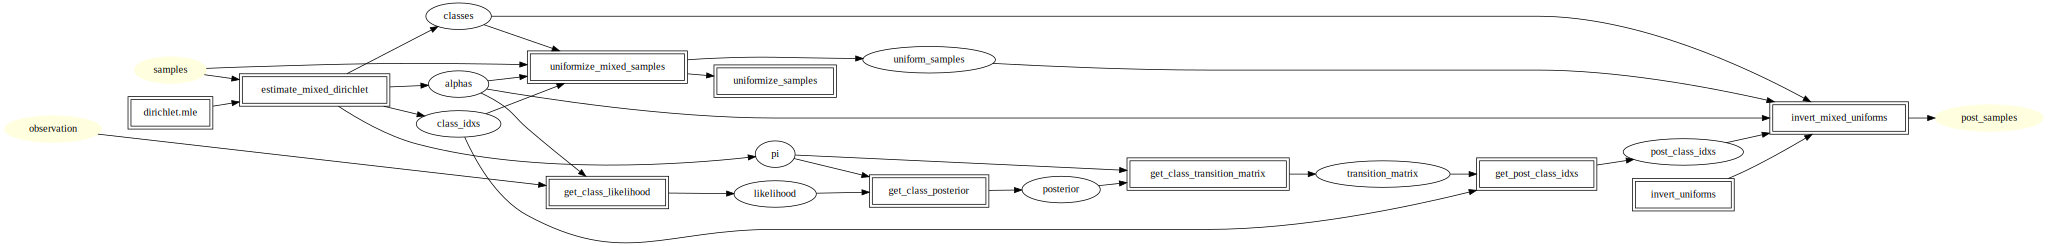

In [150]:
# Rewriting the complete code for the modified computational graph
from graphviz import Digraph

# Initialize Graphviz Digraph for the modified graph
mod_dot = Digraph()
mod_dot.attr(rankdir='LR')  # Left to right graph

# Full list of Variables and Functions
variables_mod = [
    'samples', 'observation', 'alphas', 'pi', 'classes', 'class_idxs', 
    'likelihood', 'posterior', 'uniform_samples', 'transition_matrix', 
    'post_class_idxs', 'post_samples'
]

functions_mod = [
    'estimate_mixed_dirichlet', 'dirichlet.mle', 'uniformize_samples', 
    'uniformize_mixed_samples', 'get_class_likelihood', 'get_class_posterior', 
    'get_class_transition_matrix', 'get_post_class_idxs', 'invert_uniforms', 
    'invert_mixed_uniforms'
]

# Define input nodes (to be styled differently)
input_variables = ['samples', 'observation', 'post_samples']

# Add Input Variables to the graph with distinct style
for var in input_variables:
    mod_dot.node(var, var, shape='ellipse', style='filled', color='lightyellow')

# Add other Variables to the graph
for var in set(variables_mod) - set(input_variables):
    mod_dot.node(var, var, shape='ellipse')

# Add Functions to the graph
for func in functions_mod:
    mod_dot.node(func, func, shape='rect', peripheries='2')

# Define full set of edges with the new dependency
edges_mod = {
    'samples': ['estimate_mixed_dirichlet', 'uniformize_mixed_samples'],
    'observation': ['get_class_likelihood'],
    'estimate_mixed_dirichlet': ['alphas', 'pi', 'classes', 'class_idxs'],
    'dirichlet.mle': ['estimate_mixed_dirichlet'],
    'uniformize_samples': [],
    'uniformize_mixed_samples': ['uniform_samples', 'uniformize_samples'],
    'get_class_likelihood': ['likelihood'],
    'get_class_posterior': ['posterior'],
    'get_class_transition_matrix': ['transition_matrix'],
    'get_post_class_idxs': ['post_class_idxs'],
    'invert_uniforms': ['invert_mixed_uniforms'],
    'invert_mixed_uniforms': ['post_samples'],
    'alphas': ['uniformize_mixed_samples', 'get_class_likelihood', 'invert_mixed_uniforms'],
    'classes': ['uniformize_mixed_samples', 'invert_mixed_uniforms'],
    'class_idxs': ['uniformize_mixed_samples', 'get_post_class_idxs'],
    'pi': ['get_class_posterior', 'get_class_transition_matrix'],
    'likelihood': ['get_class_posterior'],
    'posterior': ['get_class_transition_matrix'],
    'uniform_samples': ['invert_mixed_uniforms'],
    'transition_matrix': ['get_post_class_idxs'],
    'post_class_idxs': ['invert_mixed_uniforms']
}

# Add edges to the graph
for start, ends in edges_mod.items():
    for end in ends:
        mod_dot.edge(start, end)

# Hint to place 'observation' to the left
mod_dot.edge('observation', 'samples', style='invis')

# Render the modified graph
mod_dot



In [ ]:
# Order of function implementation
1. dirichlet.mle ✓
2. est_mixed_dirichlet ✓
3. uniformize_samples ✓
4. uniformize_mixed_samples ✓
5. get_likelihood ✓
6. get_posterior ✓
7. get_transformation_matrix ✓
8. get_post_class_idxs ✓
9. invert_uniforms ✓
10. invert_mixed_uniforms ✓
11. get_post_class_idxs_pipeline ✓
12. transport_pipeline ✓

In [185]:
import simple_class_transport as sct
%load_ext autoreload
%autoreload 2

samples = np.array([[0.1, 0.1, 0.8],
                    [0.2, 0.2, 0.6],
                    [0.3, 0.3, 0.4]])
observation = 0.2
sct.transport_pipeline(samples, observation)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0.1 0.1 0.8]
 [0.2 0.2 0.6]
 [0.3 0.3 0.4]]
classes: [[ True  True  True]]
class_idxs: [0 0 0]
alphas: [[3.4404923  3.4404923  9.87527507]]
pi: [1.]
U: [[0.12778514 0.08666186 0.23186432]
 [0.52659047 0.51321997 0.21208937]
 [0.83668637 0.91398663 0.26499457]]
Optimized Matrix A:
 [[1.]]
post_class_idxs: [0, 0, 0]
[] [0 1 2] (array([], shape=(0, 1), dtype=int64), array([[0, 1, 2]])) [3.4404923  3.4404923  9.87527507]
X: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])